
# Training Spiking Neural Networks with MNIST Dataset


In [1]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 2.9 MB/s eta 0:00:00


In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

# 1. A Recurrent Representation of SNNs

# 5. Setting up the Static MNIST Dataset

In [6]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 616kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.53MB/s]


In [8]:
from torch.utils.data import Subset

train_indices = list(range(2400))
test_indices = list(range(600))

mnist_train_subset = Subset(mnist_train, train_indices)
mnist_test_subset = Subset(mnist_test, test_indices)




In [9]:
print('Samples in test set:',len(mnist_test))
print('Samples in train set:',len(mnist_train))

Samples in test set: 10000
Samples in train set: 60000


If the above code blocks throws an error, e.g. the MNIST servers are down, then uncomment the following code instead.

In [10]:
# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(root = './', train=False, download=True, transform=transform)

In [11]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [13]:
def split_data_into_windows(data, num_windows):
    split_data_list = []
    size_window = len(data)//num_windows

    for i in range(num_windows):
        split_data_list.append(data[i*size_window:(i+1)*size_window])


    return split_data_list


def get_n_first_frequencies_of_data(frequencies, num_samples):
    return frequencies[:num_samples]

def min_max_norm_data(data):
    data_min = data.min()
    data_max = data.max()

    if data_max == data_min:
        return np.zeros_like(data)

    return (data - data_min)/(data_max - data_min)

def preprocess_data(data, tensor_size=28):
    split_data_list = split_data_into_windows(data, tensor_size)

    data_tensor = np.empty((tensor_size, tensor_size))

    for i, time_window in enumerate(split_data_list):
        #print(i)
        fft_result_temp = np.fft.fft(time_window)
        frequencies_temp = np.fft.fftfreq(len(fft_result_temp), d=1/sample_rate)
        #print(fft_result_temp)
        sampled_freq = np.abs(get_n_first_frequencies_of_data(fft_result_temp, tensor_size))
        #print(sampled_freq)
        data_tensor[i] = np.log(sampled_freq + 1e5)


    return min_max_norm_data(data_tensor)



In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import os
from tqdm import tqdm
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

data_dict = {}

for num in range(0, 10):
    data_dict[str(num)] = []


directory = "/content/drive/MyDrive/recordings"

for filename in tqdm(os.listdir(directory)):
    if os.path.isfile(os.path.join(directory, filename)):
      if filename.endswith(".wav"):
        #print(filename)
        sample_rate, audio_data = wav.read(f"{directory}/{filename}")
        label = filename.split("_")[0]
        # print(f"Filename {filename} - label {label}")

        data_tensor = preprocess_data(audio_data, 28)
        data_dict[label].append(data_tensor)
      else:
        print("wrong format")

100%|██████████| 3001/3001 [01:38<00:00, 30.50it/s] 

wrong format


In [16]:
class FreeSpokenDigitsDatatset(Dataset):
    def __init__(self, matrix_dict, pooling_threshold=2):
        self.data = []
        self.labels = []

        for digit_str, matrices in matrix_dict.items():
            digit_int = int(digit_str)

            for matrix in tqdm(matrices):

                tensor_matrix = torch.from_numpy(matrix).float()

                self.data.append(tensor_matrix)
                self.labels.append(digit_int)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [17]:
dataset = FreeSpokenDigitsDatatset(data_dict)
batch_size = 32

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

100%|██████████| 300/300 [00:00<00:00, 55239.09it/s]

Train samples: 2400, Val samples: 600


In [18]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

# Transform MNIST
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])

# load MNIST
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

#load FSDD
class FreeSpokenDigitsDataset(Dataset):
    def __init__(self, matrix_dict):
        self.data = []
        self.labels = []
        for digit_str, matrices in matrix_dict.items():
            digit_int = int(digit_str)
            for matrix in tqdm(matrices, desc=f"Loading digit {digit_str}"):
                tensor_matrix = torch.from_numpy(matrix).float()
                self.data.append(tensor_matrix)
                self.labels.append(digit_int)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# dataset = FreeSpokenDigitsDataset(data_dict)

# MNIST
mnist_by_digit = {d: [] for d in range(10)}
print(mnist_by_digit)
for img, label in tqdm(mnist_train):
    if len(mnist_by_digit[label]) < 300:  # collect only up to 300 per digit
        mnist_by_digit[label].append(img)

# FSDD
fsd_by_digit = {d: [] for d in range(10)}
for audio, label in tqdm(dataset):  # <-- your FSD dataset here
    if len(fsd_by_digit[label]) < 300:  # collect only up to 300 per digit
        fsd_by_digit[label].append(audio)

# ensure its 300 per digit
for d in tqdm(range(10)):
    if len(mnist_by_digit[d]) < 300 or len(fsd_by_digit[d]) < 300:
        raise ValueError(f"Not enough samples for digit {d} in one of the datasets.")

    random.shuffle(mnist_by_digit[d])
    random.shuffle(fsd_by_digit[d])

# final dataset
rows = []
for d in tqdm(range(10)):
    for i in range(300):
        rows.append({
            "Digit": d,
            "MNIST Data": list(mnist_by_digit[d][i]),
            "Audio Data": list(fsd_by_digit[d][i])
        })

df = pd.DataFrame(rows)

# save to csv
output_csv_path = './mnist_fsd_balanced.csv'
df.to_csv(output_csv_path, index=False)
print(f"CSV file saved to {output_csv_path}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 22.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 619kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.82MB/s]


{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}


100%|██████████| 10/10 [00:00<00:00, 29.15it/s]


CSV file saved to ./mnist_fsd_balanced.csv


In [19]:
combinded_dataset_dict = {d: [] for d in range(10)}

class CombinedDataset(Dataset):
    def __init__(self, matrix_dict, pooling_threshold=2):
        self.data = []
        self.labels = []

        for digit_int, matrices in matrix_dict.items():

            for matrix in tqdm(matrices):

                #tensor_matrix = torch.from_numpy(matrix).float()

                self.data.append(matrix)
                self.labels.append(digit_int)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

for key in range(0, 10):
    for i in range(0, 300):
        #print(len(mnist_by_digit[key][i][0]))
        #print(len(fsd_by_digit[key][i]))
        #print("added", len(mnist_by_digit[key][i][0] + fsd_by_digit[key][i]))
        combinded_dataset_dict[key].append(mnist_by_digit[key][i][0] + fsd_by_digit[key][i])

batch_size = 32

combined_dataset = CombinedDataset(combinded_dataset_dict)

train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset_combined, val_dataset_combined = torch.utils.data.random_split(
    combined_dataset, [train_size, val_size]
)

#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
#test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")


100%|██████████| 300/300 [00:00<00:00, 1442994.50it/s]

Train samples: 2400, Val samples: 600


In [20]:
len(df["MNIST Data"][0][0])

28

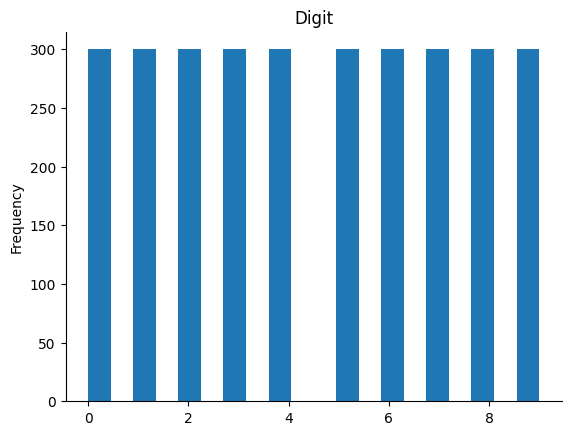

In [21]:
# @title Digit

from matplotlib import pyplot as plt
df['Digit'].plot(kind='hist', bins=20, title='Digit')
plt.gca().spines[['top', 'right',]].set_visible(False)

# 6. Define the Network

In [90]:
# Network Architecture
num_inputs = 28*28
num_hidden = 256
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [91]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def _initialize_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

The code in the `forward()` function will only be called once the input argument `x` is explicitly passed into `net`.

* `fc1` applies a linear transformation to all input pixels from the MNIST dataset;
* `lif1` integrates the weighted input over time, emitting a spike if the threshold condition is met;
* `fc2` applies a linear transformation to the output spikes of `lif1`;
* `lif2` is another spiking neuron layer, integrating the weighted spikes over time.

# 7. Training the SNN

## 7.1 Accuracy Metric
Below is a function that takes a batch of data, counts up all the spikes from each neuron (i.e., a rate code over the simulation time), and compares the index of the highest count with the actual target. If they match, then the network correctly predicted the target.

In [92]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target#

def give_batch_acc(data, targets):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())
    return acc * 100


def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

## 7.2 Loss Definition
The `nn.CrossEntropyLoss` function in PyTorch automatically handles taking the softmax of the output layer as well as generating a loss at the output.

In [93]:
loss = nn.CrossEntropyLoss()

## 7.3 Optimizer
Adam is a robust optimizer that performs well on recurrent networks, so let's use that with a learning rate of $5\times10^{-4}$.

In [94]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

## 7.5 Training Loop

Let's combine everything into a training loop. We will train for one epoch (though feel free to increase `num_epochs`), exposing our network to each sample of data once.

In [95]:
dataset_to_use = "combined_small"
batch_size = 32

In [96]:
def define_dataset(dataset_to_use):

    if dataset_to_use == "mnist":
        train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)
        print("### Using MNIST Dataset ###")

    elif dataset_to_use == "mnist_small":
        train_loader = DataLoader(mnist_train_subset, batch_size=batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(mnist_test_subset, batch_size=batch_size, shuffle=True, drop_last=True)
        print("### Using subsample of MNIST Dataset ###")

    elif dataset_to_use == "combined_small":
        train_loader = DataLoader(train_dataset_combined, batch_size=batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(val_dataset_combined, batch_size=batch_size, shuffle=True, drop_last=True)
        print("### Using combined Dataset ###")

    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        print("### Using Free-Speech-Data Dataset ###")

    return train_loader, test_loader

In [97]:
def train_snn(train_loader, test_loader):
    num_epochs = 10
    acc_hist_test = []
    acc_hist_train = []
    loss_hist = []
    test_loss_hist = []

    acc_hist_test_plot = []
    acc_hist_train_plot = []
    loss_hist_plot = []
    test_loss_hist_plot = []
    counter = 0

    # Outer training loop
    for epoch in range(num_epochs):

        iter_counter = 0
        train_batch = iter(train_loader)

        # Minibatch training loop
        for data, targets in train_batch:
            full_mini_batch_loss = 0
            full_mini_batch_loss_test = 0

            data = data.to(device)
            targets = targets.to(device)

            # forward pass
            net.train()
            spk_rec, mem_rec = net(data.view(batch_size, -1))

            # initialize the loss & sum over time
            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                loss_val += loss(mem_rec[step], targets)

            full_mini_batch_loss += loss_val.item()

            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())
            acc_hist_train.append(give_batch_acc(data, targets))

            # Test set
            with torch.no_grad():
                net.eval()
                test_data, test_targets = next(iter(test_loader))
                test_data = test_data.to(device)
                test_targets = test_targets.to(device)

                # Test set forward pass
                test_spk, test_mem = net(test_data.view(batch_size, -1))

                # Test set loss
                test_loss = torch.zeros((1), dtype=dtype, device=device)
                for step in range(num_steps):
                    test_loss += loss(test_mem[step], test_targets)

                full_mini_batch_loss_test += test_loss.item()

                test_loss_hist.append(test_loss.item())
                acc_hist_test.append(give_batch_acc(test_data, test_targets))

                # Print train/test loss/accuracy
                if counter % 50 == 0:
                    train_printer(
                        data, targets, epoch,
                        counter, iter_counter,
                        loss_hist, test_loss_hist,
                        test_data, test_targets)
                counter += 1
                iter_counter +=1

        test_loss_hist_plot.append(full_mini_batch_loss_test)
        print(f"Full minibatch test loss: {full_mini_batch_loss_test}")
        print(f"Full minibatch train loss: {full_mini_batch_loss}")
        acc_hist_test_plot.append(give_batch_acc(test_data, test_targets))
        loss_hist_plot.append(full_mini_batch_loss)
        acc_hist_train_plot.append(give_batch_acc(data, targets))

    return acc_hist_train_plot, acc_hist_test_plot, loss_hist_plot, test_loss_hist_plot


If this was your first time training an SNN, then congratulations!

# 8. Results
## 8.1 Plot Training/Test Loss

In [98]:
def plot_acc(acc_hist_train, acc_hist_test, fig_name):
    fig = plt.figure(facecolor="w", figsize=(10, 5))
    plt.plot(acc_hist_train)
    plt.plot(acc_hist_test)
    print((acc_hist_train == acc_hist_test))
    plt.title("Accracy Curves")
    plt.legend(["Train Accuracy", "Test Accuracy"])
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy in %")
    plt.show()
    plt.savefig(f"{fig_name}.png")

In [99]:
def plot_loss(loss_hist, test_loss_hist, fig_name):
    fig = plt.figure(facecolor="w", figsize=(10, 5))
    plt.plot(loss_hist)
    plt.plot(test_loss_hist)
    plt.title("Loss Curves")
    plt.legend(["Train Loss", "Test Loss"])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()
    plt.savefig(f"{fig_name}.png")

The loss curves are noisy because the losses are tracked at every iteration, rather than averaging across multiple iterations.

In [100]:
def reset_weights():
    net = Net().to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9, 0.999))


## 8.2 Compare mini mnist to Free Spoken Digits

### Using subsample of MNIST Dataset ###
Epoch 0, Iteration 0
Train Set Loss: 84.57
Test Set Loss: 71.65
Train set accuracy for a single minibatch: 28.12%
Test set accuracy for a single minibatch: 18.75%


Epoch 0, Iteration 50
Train Set Loss: 16.90
Test Set Loss: 14.97
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 81.25%


Full minibatch test loss: 22.764196395874023
Full minibatch train loss: 18.49154281616211
Epoch 1, Iteration 25
Train Set Loss: 15.03
Test Set Loss: 16.37
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 87.50%


Full minibatch test loss: 12.384349822998047
Full minibatch train loss: 8.300884246826172
Epoch 2, Iteration 0
Train Set Loss: 6.11
Test Set Loss: 12.54
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 81.25%


Epoch 2, Iteration 50
Train Set Loss: 7.69
Test Set Loss: 13.78
Train set accuracy for a single minibatch: 90.62%
Test

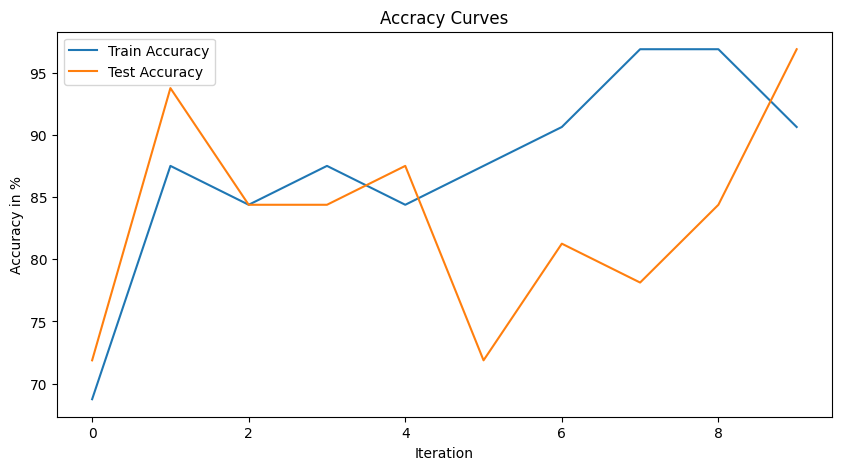

<Figure size 640x480 with 0 Axes>

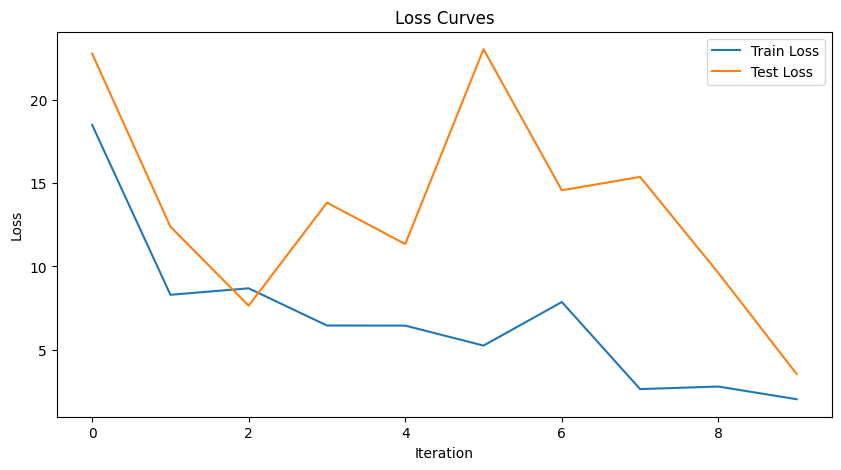

### Using Free-Speech-Data Dataset ###
Epoch 0, Iteration 0
Train Set Loss: 71.70
Test Set Loss: 71.39
Train set accuracy for a single minibatch: 21.88%
Test set accuracy for a single minibatch: 9.38%


Epoch 0, Iteration 50
Train Set Loss: 37.23
Test Set Loss: 33.13
Train set accuracy for a single minibatch: 53.12%
Test set accuracy for a single minibatch: 53.12%


Full minibatch test loss: 24.34786033630371
Full minibatch train loss: 19.929492950439453
Epoch 1, Iteration 25
Train Set Loss: 36.32
Test Set Loss: 42.06
Train set accuracy for a single minibatch: 56.25%
Test set accuracy for a single minibatch: 59.38%


Full minibatch test loss: 30.191713333129883
Full minibatch train loss: 24.88484764099121
Epoch 2, Iteration 0
Train Set Loss: 23.86
Test Set Loss: 33.03
Train set accuracy for a single minibatch: 65.62%
Test set accuracy for a single minibatch: 65.62%


Epoch 2, Iteration 50
Train Set Loss: 18.10
Test Set Loss: 27.78
Train set accuracy for a single minibatch: 87.50%
Test 

<Figure size 640x480 with 0 Axes>

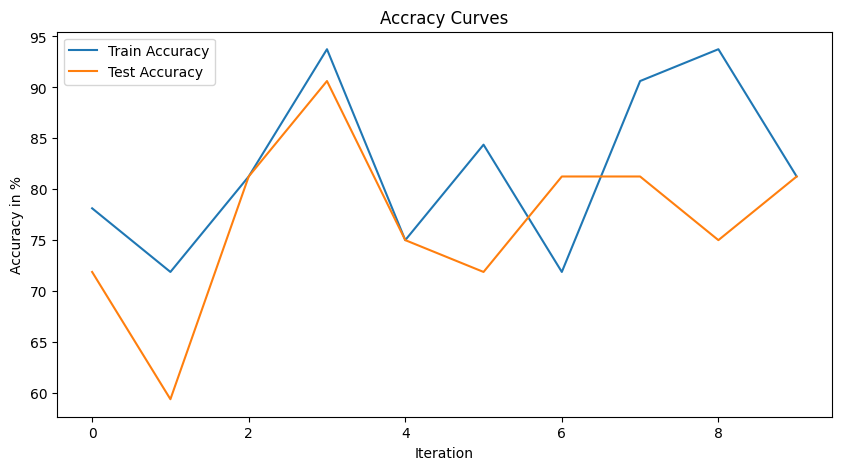

<Figure size 640x480 with 0 Axes>

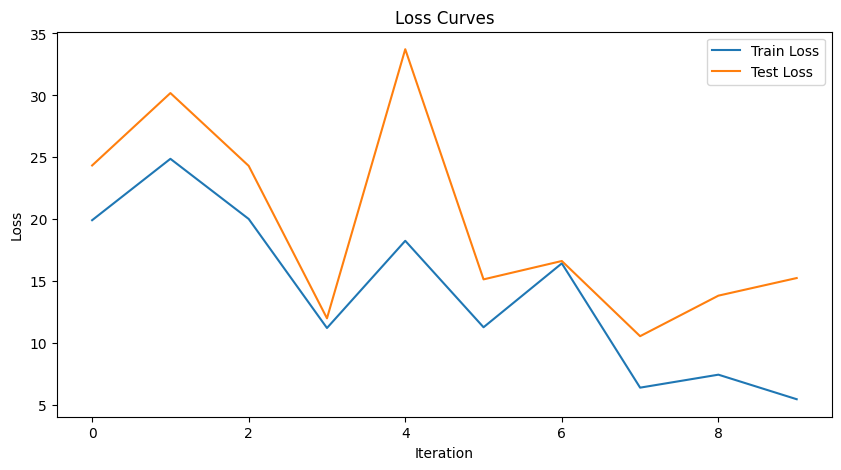

### Using combined Dataset ###
Epoch 0, Iteration 0
Train Set Loss: 92.20
Test Set Loss: 83.71
Train set accuracy for a single minibatch: 34.38%
Test set accuracy for a single minibatch: 12.50%


Epoch 0, Iteration 50
Train Set Loss: 23.50
Test Set Loss: 10.26
Train set accuracy for a single minibatch: 78.12%
Test set accuracy for a single minibatch: 81.25%


Full minibatch test loss: 4.8084869384765625
Full minibatch train loss: 9.911035537719727
Epoch 1, Iteration 25
Train Set Loss: 13.24
Test Set Loss: 4.64
Train set accuracy for a single minibatch: 84.38%
Test set accuracy for a single minibatch: 93.75%


Full minibatch test loss: 8.941864013671875
Full minibatch train loss: 3.1672325134277344
Epoch 2, Iteration 0
Train Set Loss: 4.21
Test Set Loss: 2.73
Train set accuracy for a single minibatch: 96.88%
Test set accuracy for a single minibatch: 90.62%


Epoch 2, Iteration 50
Train Set Loss: 4.19
Test Set Loss: 12.17
Train set accuracy for a single minibatch: 84.38%
Test set accurac

<Figure size 640x480 with 0 Axes>

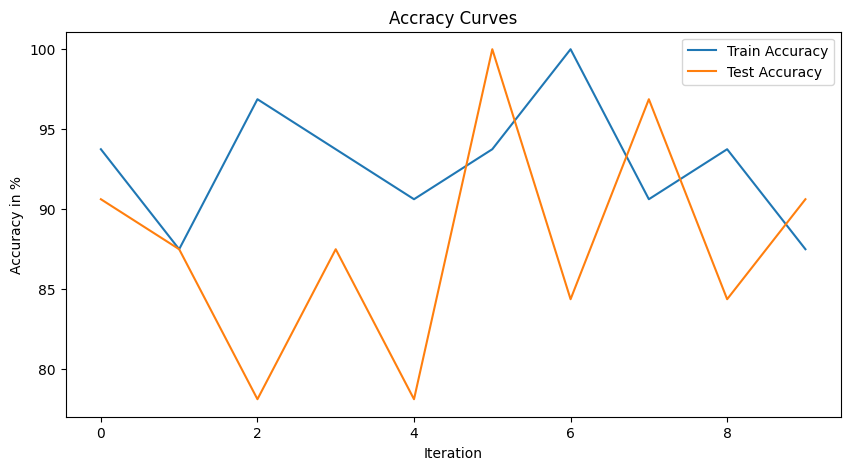

<Figure size 640x480 with 0 Axes>

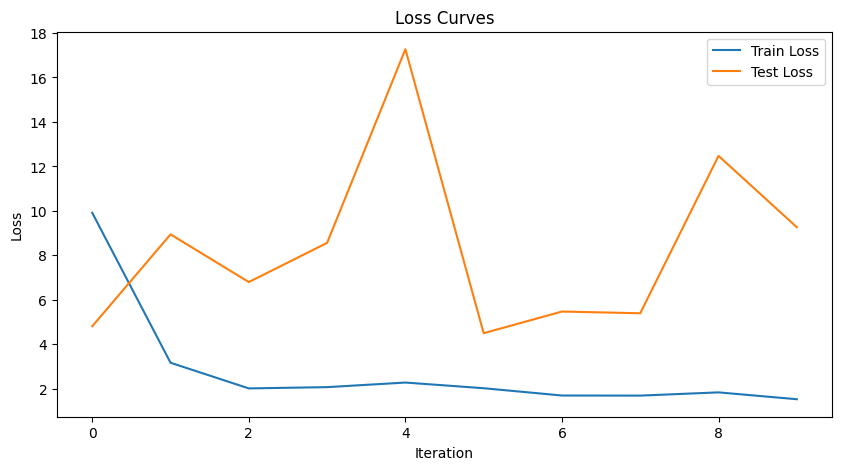

<Figure size 640x480 with 0 Axes>

In [101]:
for dataset_to_use_loop in ["mnist_small", "free_spoken_digits", "combined_small"]:
    net._initialize_weights()
    train_loader, test_loader = define_dataset(dataset_to_use_loop)
    acc_hist_train, acc_hist_test, loss_hist, test_loss_hist = train_snn(train_loader=train_loader, test_loader=test_loader)
    plot_acc(acc_hist_test=acc_hist_test, acc_hist_train=acc_hist_train, fig_name=f"acc_{dataset_to_use_loop}")
    plot_loss(loss_hist=loss_hist, test_loss_hist=test_loss_hist, fig_name=f"loss_{dataset_to_use_loop}")

    torch.save({
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss_hist': loss_hist,
        'val_loss_hist': test_loss_hist,
        'train_acc_hist': acc_hist_train,
        'val_acc_hist': acc_hist_test,
    }, f'{dataset_to_use_loop}_snn_model.pth')

    net._initialize_weights()

In [ ]:
import torch

# select gpu when available, else work with cpu resources
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net()
model.load_state_dict(torch.load('mnist_small_snn_model.pth'))

model.eval();


# Run forward pass
with torch.no_grad():
  pred = model()

# Do something with pred
pred = pred.detach().cpu().numpy() # remove from computational graph to cpu and as numpy

In [ ]:
def test_model(train_loader, test_loader):
    num_epochs = 10
    acc_hist_test = []
    acc_hist_train = []
    loss_hist = []
    test_loss_hist = []

    acc_hist_test_plot = []
    acc_hist_train_plot = []
    loss_hist_plot = []
    test_loss_hist_plot = []
    counter = 0

    # Outer training loop
    for epoch in range(num_epochs):

        iter_counter = 0
        train_batch = iter(train_loader)

        # Minibatch training loop
        for data, targets in train_batch:
            with torch.no_grad():
                net.eval()
                test_data, test_targets = next(iter(test_loader))
                test_data = test_data.to(device)
                test_targets = test_targets.to(device)

                test_spk, test_mem = net(test_data.view(batch_size, -1))

                # Test set loss
                test_loss = torch.zeros((1), dtype=dtype, device=device)
                for step in range(num_steps):
                    test_loss += loss(test_mem[step], test_targets)

                full_mini_batch_loss_test += test_loss.item()

                test_loss_hist.append(test_loss.item())
                acc_hist_test.append(give_batch_acc(test_data, test_targets))

                # Print train/test loss/accuracy
                if counter % 50 == 0:
                    train_printer(
                        data, targets, epoch,
                        counter, iter_counter,
                        loss_hist, test_loss_hist,
                        test_data, test_targets)
                counter += 1
                iter_counter +=1

        test_loss_hist_plot.append(full_mini_batch_loss_test)
        print(f"Full minibatch test loss: {full_mini_batch_loss_test}")
        #print(f"Full minibatch train loss: {full_mini_batch_loss}")
        acc_hist_test_plot.append(give_batch_acc(test_data, test_targets))
        #loss_hist_plot.append(full_mini_batch_loss)
        acc_hist_train_plot.append(give_batch_acc(data, targets))

    return acc_hist_train_plot, acc_hist_test_plot, loss_hist_plot, test_loss_hist_plot


## 8.2 Test Set Accuracy
This function iterates over all minibatches to obtain a measure of accuracy over the full 10,000 samples in the test set.

In [106]:
model = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)  # or whatever you used

# 2. Load checkpoint
checkpoint = torch.load("combined_small_snn_model.pth", map_location="cpu", weights_only=False)


# 3. Restore model and optimizer state dicts
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# 4. Extract training history if needed
train_loss_hist = checkpoint['train_loss_hist']
val_loss_hist   = checkpoint['val_loss_hist']
train_acc_hist  = checkpoint['train_acc_hist']
val_acc_hist    = checkpoint['val_acc_hist']

print("Model and optimizer successfully loaded!")

Model and optimizer successfully loaded!


In [146]:
def test_model(results, model_name, dataset_name, index):
    total = 0
    correct = 0

    model = Net()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)  # or whatever you used

    # 2. Load checkpoint
    checkpoint = torch.load(f"{model_name}", map_location="cpu", weights_only=False)


    # 3. Restore model and optimizer state dicts
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # 4. Extract training history if needed
    train_loss_hist = checkpoint['train_loss_hist']
    val_loss_hist   = checkpoint['val_loss_hist']
    train_acc_hist  = checkpoint['train_acc_hist']
    val_acc_hist    = checkpoint['val_acc_hist']

    print("Model and optimizer successfully loaded!")

    #model = Net()
    #model.load_state_dict(torch.load('combined_small_snn_model.pth'), weighs_only=False)

    # drop_last switched to False to keep all samples
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

    with torch.no_grad():
        model.eval()
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)

            # forward pass
            test_spk, _ = model(data.view(data.size(0), -1))

            # calculate total accuracy
            _, predicted = test_spk.sum(dim=0).max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        print(f"Total correctly classified test set images: {correct}/{total}")
        print(f"Test Set Accuracy: {100 * correct / total:.2f}%")
        results[f"{model_name}_{index}"] = 100 * correct / total


    return results

In [147]:
results = {}

for models in ["combined_small_snn_model.pth", "free_spoken_digits_snn_model.pth", "mnist_small_snn_model.pth"]:
    for i, dataset_name in enumerate([mnist_train, mnist_test, train_dataset, train_dataset_combined, val_dataset_combined]):
        #print(f"Model: {models}\n Dataset: {str(dataset_name)} \n\n")
        results = test_model(model_name=f"{models}", dataset_name=dataset_name, index=i, results=results)

print(results)

Model and optimizer successfully loaded!
Total correctly classified test set images: 7710/10000
Test Set Accuracy: 77.10%
Model and optimizer successfully loaded!
Total correctly classified test set images: 7710/10000
Test Set Accuracy: 77.10%
Model and optimizer successfully loaded!
Total correctly classified test set images: 7710/10000
Test Set Accuracy: 77.10%
Model and optimizer successfully loaded!
Total correctly classified test set images: 7710/10000
Test Set Accuracy: 77.10%
Model and optimizer successfully loaded!
Total correctly classified test set images: 7710/10000
Test Set Accuracy: 77.10%
Model and optimizer successfully loaded!
Total correctly classified test set images: 1480/10000
Test Set Accuracy: 14.80%
Model and optimizer successfully loaded!
Total correctly classified test set images: 1480/10000
Test Set Accuracy: 14.80%
Model and optimizer successfully loaded!
Total correctly classified test set images: 1480/10000
Test Set Accuracy: 14.80%
Model and optimizer succ

In [139]:
print(results)

{'mnist_small_snn_model.pth_4': 84.6}


Voila! That's it for static MNIST. Feel free to tweak the network parameters, hyperparameters, decay rate, using a learning rate scheduler etc. to see if you can improve the network performance.

# Conclusion
Now you know how to construct and train a fully-connected network on a static dataset. The spiking neurons can also be adapted to other layer types, including convolutions and skip connections. Armed with this knowledge, you should now be able to build many different types of SNNs. [In the next tutorial](https://snntorch.readthedocs.io/en/latest/tutorials/index.html), you will learn how to train a spiking convolutional network, and simplify the amount of code required using the `snn.backprop` module.




# Additional Resources



* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)

This Implementation is based on below referenced paper.

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

In [ ]:
def func(num):
    return num + 5, num - 5



In [ ]:
result1, result2 = func(num=5)

In [ ]:
print(result2)